# Searching and Accessing ICESat-2 Sea Ice Freeboard for the MOSAiC Campaign

The MOSAiC Campaign was a multi-disciplinary campaign to observe the Arctic sea ice, atmosphere, and upper ocean for a whole year.  The Alfred Wegner Instititute's (AWI) research vessel, The Polarstern, was frozen into the sea ice near the north pole in September 2019 (just before COVID hit) and allowed to drift with the sea ice.  It is interesting to compare the wealth of _in-situ_ observations collected during the campaign with remote sensing retrievals.  

In this notebook we demonstrate how to use `earthaccess` to search for sea ice freeboard derived from the ICESat-2 lidar altimeter that is coincident in time and space with the drift of the Polarstern.  Freeboard is the height of the ice or snow surface above the local sea surface, which is used to estimate ice thickness.  Sea ice thickness is a critical variable for understanding the changing Arctic.  Many thickness measurements were made during MOSAiC.  So we have a lot of data to make comparisons with.

![The Polarstern during the MOSAiC Campaign](../images/polarstern.jpg)

In [1]:
from pathlib import Path
import datetime as dt

# For search and access
import earthaccess

# For reading data
import pandas as pd
import geopandas as gpd
import xarray as xr
from shapely.geometry import LineString

# For plotting data
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

POLARSTERN_DRIFT_FILE = Path("../data/polarstern_track_full_cruise_processed.geojson")

# Load Polarstern Drift data

I've processed th original Polarstern location files to remove locations when the ship was not moored to icefloes and sample only midday locations.  Locations in the original file are provided every 10 minutes.  The code used to to this can be found in `process_polarstern_track.py`.  The file is saved as a GeoJSON file, a standard geospatial vector file format.

We'll use `geopandas` to load this processed Polarstern drift into a `geopandas.GeoDataFrame`.

In [2]:
gdf = gpd.read_file(POLARSTERN_DRIFT_FILE)
gdf["Date/Time"] = pd.to_datetime(gdf["Date/Time"])
gdf = gdf.set_index("Date/Time", drop=True)
gdf.head()

,Latitude,Longitude,Speed [kn],Course [deg],Floe,geometry
Date/Time,,,,,,
2020-02-24 12:00:00,88.58853,54.40375,0.573,264.4,1,POINT (54.40375 88.58853)
2020-02-25 12:00:00,88.56073,45.77189,0.497,256.1,1,POINT (45.77189 88.56073)
2020-02-26 12:00:00,88.48884,40.03024,0.369,236.8,1,POINT (40.03024 88.48884)
2020-02-27 12:00:00,88.41034,36.68964,0.291,230.7,1,POINT (36.68964 88.41034)
2020-02-28 12:00:00,88.34216,33.84290,0.241,227.2,1,POINT (33.8429 88.34216)


A good first step with any data is to plot it.  We'll make a map in the NSIDC North Polar Steographic coordinate reference system (CRS) to show the locations of the Polarstern.  

Because the ice drift was unusually fast, and because the ship had to leave the floe to pick up a new crew, the ship had to find new floes, these are indicated by the different coloured dots.

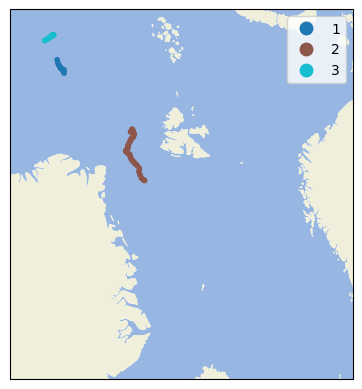

In [3]:
projection = ccrs.Stereographic(central_latitude=90., central_longitude=-45., true_scale_latitude=70.)

fig, ax = plt.subplots(subplot_kw=dict(projection=projection))
ax.set_extent([-200000., 2349878.8355433857, -2349878.8355433852, 400000.],projection)

gdf.to_crs(3413).plot(ax=ax, column="Floe", markersize=10, legend=True, categorical=True)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)

# Find ICESat-2 Track within 20 km of Polarstern

In [4]:
auth = earthaccess.login()

In [5]:
%%time

radius = 20000  # Radius of search

results = {}
for date, fields in gdf.iterrows():
    dbeg = date - dt.timedelta(hours=12)
    dend = date + dt.timedelta(hours=12)
    r = earthaccess.search_data(
        short_name="ATL10",
        temporal=(dbeg.isoformat(), dend.isoformat()),
        circle=(fields.Longitude, fields.Latitude, radius),
        version="006",
    )

    if len(r) > 0:
        results[date.isoformat()] = r

CPU times: user 1.09 s, sys: 35.7 ms, total: 1.12 s
Wall time: 36.9 s


# Visualize some results

There are 68 ICESat-2 tracks that coincide with the drift of the Polarstern.  This takes a long time to load.  We will visualize one of these tracks for this demonstration.

Rather than downloading the data, we will stream it directly from the NASA Earthdata Cloud S3 bucket.  We can do this because we are working on a cloud compute instance in the same AWS region (us-west-2) as the NASA Earthdata Cloud.  You could use this approach if you were working locally but it would take a long time.

We use the `earthaccess.open` method to create virtual file objects.  These virtual file objects allow us to work with files stored on S3 just as if they were stored on our local file system.

In [6]:
files = earthaccess.open(results['2020-08-31T12:00:00'])

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

ICESat-2 files are in HDF5 format, which is a nested set of groups and variables.  We can use `xarray.open_datatree` to load tese kinds of files.  At the moment, `open_datatree` can only only a single file.

In [7]:
ds = xr.open_datatree(files[1], decode_timedelta=False, phony_dims='sort')
ds

<xarray.DataTree>
Group: /
│   Attributes: (12/47)
│       short_name:                         ATL10
│       level:                              L3A
│       title:                              SET_BY_META
│       description:                        This data set (ATL10) contains along-...
│       Conventions:                        CF-1.6
│       contributor_name:                   Ron Kwok (rkwok01@uw.edu), Alek Petty...
│       ...                                 ...
│       processing_level:                   2A
│       references:                         http://nsidc.org/data/icesat2/data.html
│       project:                            ICESat-2 > Ice, Cloud, and land Eleva...
│       instrument:                         ATLAS > Advanced Topographic Laser Al...
│       platform:                           ICESat-2 > Ice, Cloud, and land Eleva...
│       source:                             Spacecraft
├── Group: /ancillary_data
│   │   Dimensions:              (phony_dim_0: 1)
│   │   Dimensions without coordinates: phony_dim_0
│   │   Data variables: (12/24)
│   │       atlas_sdp_gps_epoch  (phony_dim_0) datetime64[ns] 8B ...
│   │       control              (phony_dim_0) |S100000 100kB ...
│   │       data_end_utc         (phony_dim_0) |S27 27B ...
│   │       data_start_utc       (phony_dim_0) |S27 27B ...
│   │       end_cycle            (phony_dim_0) int32 4B ...
│   │       end_delta_time       (phony_dim_0) datetime64[ns] 8B ...
│   │       ...                   ...
│   │       start_gpssow         (phony_dim_0) float64 8B ...
│   │       start_gpsweek        (phony_dim_0) int32 4B ...
│   │       start_orbit          (phony_dim_0) int32 4B ...
│   │       start_region         (phony_dim_0) int32 4B ...
│   │       start_rgt            (phony_dim_0) int32 4B ...
│   │       version              (phony_dim_0) |S80 80B ...
│   │   Attributes:
│   │       Description:  Contains information ancillary to the data product. This ma...
│   └── Group: /ancillary_data/freeboard_estimation
│           Dimensions:                              (phony_dim_1: 1)
│           Dimensions without coordinates: phony_dim_1
│           Data variables: (12/31)
│               b_fr                                 (phony_dim_1) float32 4B ...
│               fbswath_fb_hist_max                  (phony_dim_1) float32 4B ...
│               fbswath_fb_hist_min                  (phony_dim_1) float32 4B ...
│               fill_height_pct                      (phony_dim_1) float32 4B ...
│               fill_snow_depth                      (phony_dim_1) float32 4B ...
│               fill_ub_width                        (phony_dim_1) float32 4B ...
│               ...                                   ...
│               refsurf_h_offset1                    (phony_dim_1) float32 4B ...
│               refsurf_h_offset2                    (phony_dim_1) float32 4B ...
│               refsurf_sd_fill                      (phony_dim_1) float32 4B ...
│               refsurf_slope_fill                   (phony_dim_1) float32 4B ...
│               refsurf_slope_ub                     (phony_dim_1) float32 4B ...
│               ub_refsurf                           (phony_dim_1) float32 4B ...
│           Attributes:
│               Description:  Contains ancillary parameters related to the surface classi...
├── Group: /orbit_info
│       Dimensions:         (crossing_time: 1, sc_orient_time: 1)
│       Coordinates:
│         * crossing_time   (crossing_time) datetime64[ns] 8B 2020-08-31T17:28:22.762...
│         * sc_orient_time  (sc_orient_time) datetime64[ns] 8B 2020-08-30T23:30:00
│       Data variables:
│           cycle_number    (crossing_time) int8 1B ...
│           lan             (crossing_time) float64 8B ...
│           orbit_number    (crossing_time) uint16 2B ...
│           rgt             (crossing_time) int16 2B ...
│           sc_orient       (sc_orient_time) int8 1B ...
│       Attributes:
│           Description:  Contains orbit info

ICESat-2 data are collected for six beams, organized into three ground tracks.  To plot the data we will get coordinates for one of these beams.  Ground track data are stored in groups named gt1l, gt1r, gt2l, gt2r, gt3l, gt3r, representing grounds tracks 1, 2, and 3 with left and right beams.  We'll use beam gt1l.

Within each beam group, there are sub-groups, and then data variables.  The coordinate information is in `/gt1l/freeboard_segment/longitude` and `/gt1l/freeboard_segment/latitude`.  For plotting we don't need every point, there are over 45000 points, so we'll get every 1000th point.

In [8]:
longitude = ds["/gt1l/freeboard_segment/longitude"][::1000]
latitude = ds["/gt1l/freeboard_segment/latitude"][::1000]

We could just use `matplotlib.pyplot.plot` to plot these points but plotting points with geographic coordinates in polar regions often yields wierd results.  Points need to be converted to projected coordinates.  In this case, the NSIDC North Polar Stereographic CRS.  An easy way to do this is to use `geopandas` to do the coordinate transformation.

To do this we create a vector `LineString` object using the shapely library.  We use a list comprehension to convert the longitude and latitude arrays to a list of tuples containing coordinate pairs.  This `line` is then passed as the geometry to a `geopandas.GeoDataFrame`.  We use the `crs` keyword to assign the WGS84 CRS (EPSG code 4326) to the object. 

In [9]:
line = LineString([(lon, lat) for lon, lat in zip(longitude, latitude)])
is2_gdf = gpd.GeoDataFrame(geometry=[line], crs="EPSG:4326")

# Plot the results

We use the same plotting routine to plot the Polarstern drift and add the ICESat-2 track, which we transform from WGS84 to NSIDC North Polar Stereographic using the `to_crs` method.

<GeoAxes: >

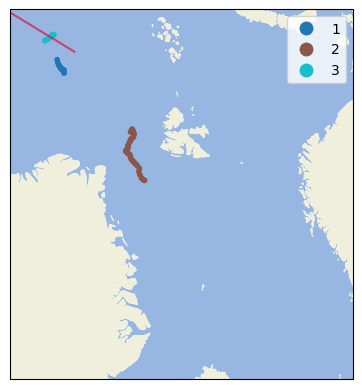

In [10]:
projection = ccrs.Stereographic(central_latitude=90., central_longitude=-45., true_scale_latitude=70.)

fig, ax = plt.subplots(subplot_kw=dict(projection=projection))
# ax.set_extent([-2349878.8355433852, 2349878.8355433857, -2349878.8355433852, 2349878.8355433857],projection)
ax.set_extent([-200000., 2349878.8355433857, -2349878.8355433852, 400000.],projection)

gdf.to_crs(3413).plot(ax=ax, column="Floe", markersize=10, legend=True, categorical=True)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)

is2_gdf.to_crs(3413).plot(ax=ax, color="crimson", markersize=1, alpha=0.7)

# Bonus Material: plot all ICESat-2 tracks

We've demonstrated accessing one file.  The following code gets the ICESat-2 tracks for all of the files.

The `results` are in a dictionary.  To open all of the files, we convert that dictionary into a single list and then use `earthaccess.open`, as we did above.

In [11]:
# Convert dictionary of `results` to a list of results
list_of_results = [r for res in results.values() for r in res]

# Open files as virtual file system
files = earthaccess.open(list_of_results)

QUEUEING TASKS | :   0%|          | 0/68 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/68 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/68 [00:00<?, ?it/s]

In the example above we used `xarray` to read the data from the ICESat-2 files and then extracted the ICESat-2 beam coordinates to create a `geopandas.DataFrame`.  A useful way to keep code clean, is to create functions for a particular task.  Here, I have created the function `beams_to_geopandas` and stored it in the `helpers.py` module that performs all of these steps.  Take a look in `helpers.py` to see how this was done.

One the `helpers` module has been created, we `import` `beams_to_geopandas` as we would for any other Python package.

_Note: this fails for one or more files, so I just run it for the first 20 files until I can troubleshoot the 

In [15]:
%%time

from helper import beams_to_geopandas

all_is2_gdf = beams_to_geopandas(files[:20])

CPU times: user 6min, sys: 5.05 s, total: 6min 5s
Wall time: 6min 36s


We can then plot the ICESat-2 tracks using the same plotting code as above.

<GeoAxes: >

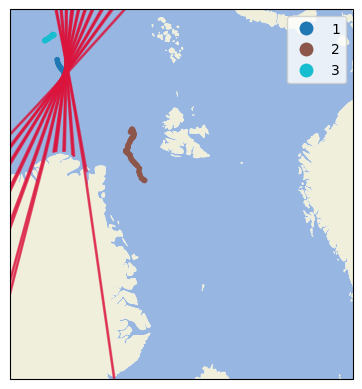

In [17]:
projection = ccrs.Stereographic(central_latitude=90., central_longitude=-45., true_scale_latitude=70.)

fig, ax = plt.subplots(subplot_kw=dict(projection=projection))
# ax.set_extent([-2349878.8355433852, 2349878.8355433857, -2349878.8355433852, 2349878.8355433857],projection)
ax.set_extent([-200000., 2349878.8355433857, -2349878.8355433852, 400000.],projection)

gdf.to_crs(3413).plot(ax=ax, column="Floe", markersize=10, legend=True, categorical=True)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)

all_is2_gdf.to_crs(3413).plot(ax=ax, color="crimson", markersize=1, alpha=0.5)

# Extra Credit!

## Filter file list

We have a list of ICESat-2 files that coincide with the Polarstern drift.  You may want to filter this list some more.  For example, for some days there are multiple granules available.  We originally searched for all ICESat-2 tracks with 20 km of the Polarstern.  You may want to find the closest track.  Look at Geopandas to see how you might do this.

Hint: use the `geopandas.DataFrame` Polarstern and coordinates for each ICESat-2 track on a given day to find the closest track.

## Subset data

ICESat-2 data files are big.  Subsetting this data for a smaller region over the Polarstern would speed up your workflow.  Look at the `xarray` user guide to see if you can figure out how to do this.

Hint: the `loc` and `sel` methods allow you to subset data.